<a href="https://colab.research.google.com/github/Nina-Om/ArcGIS-MapBook-Toolbox/blob/master/1_Prepare_AtmVar_Forecast_BOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regional monthly ERA5 Reanalysis and ECMWF forecast data
This notebook appends monthly ERA5 and ECMWF forecast data to the existing data files stored on the drive. It clips these datasets to the AZ_East, AZ_West, NM_South and NM_North regions and calculates mean areal values for each variable within these areas.

**Author**: Nina Omani (nomani@ucar.edu)\
**Date created**: 5/9/2024  \
**Date modified:** 9/22/2025

# **Download ECMWF seasonal forecast data from the Copernicus data server.**

**Option1:**
*   Monthly average ECMWF data on single level can be downloaded from the [Seasonal forecast monthly statistics on single level](https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=download)
*   Monthly average ECMWF data on pressure level can be downloaded from the
[Seasonal forecast monthly statistics on pressure level](https://cds.climate.copernicus.eu/datasets/seasonal-monthly-pressure-levels?tab=download)

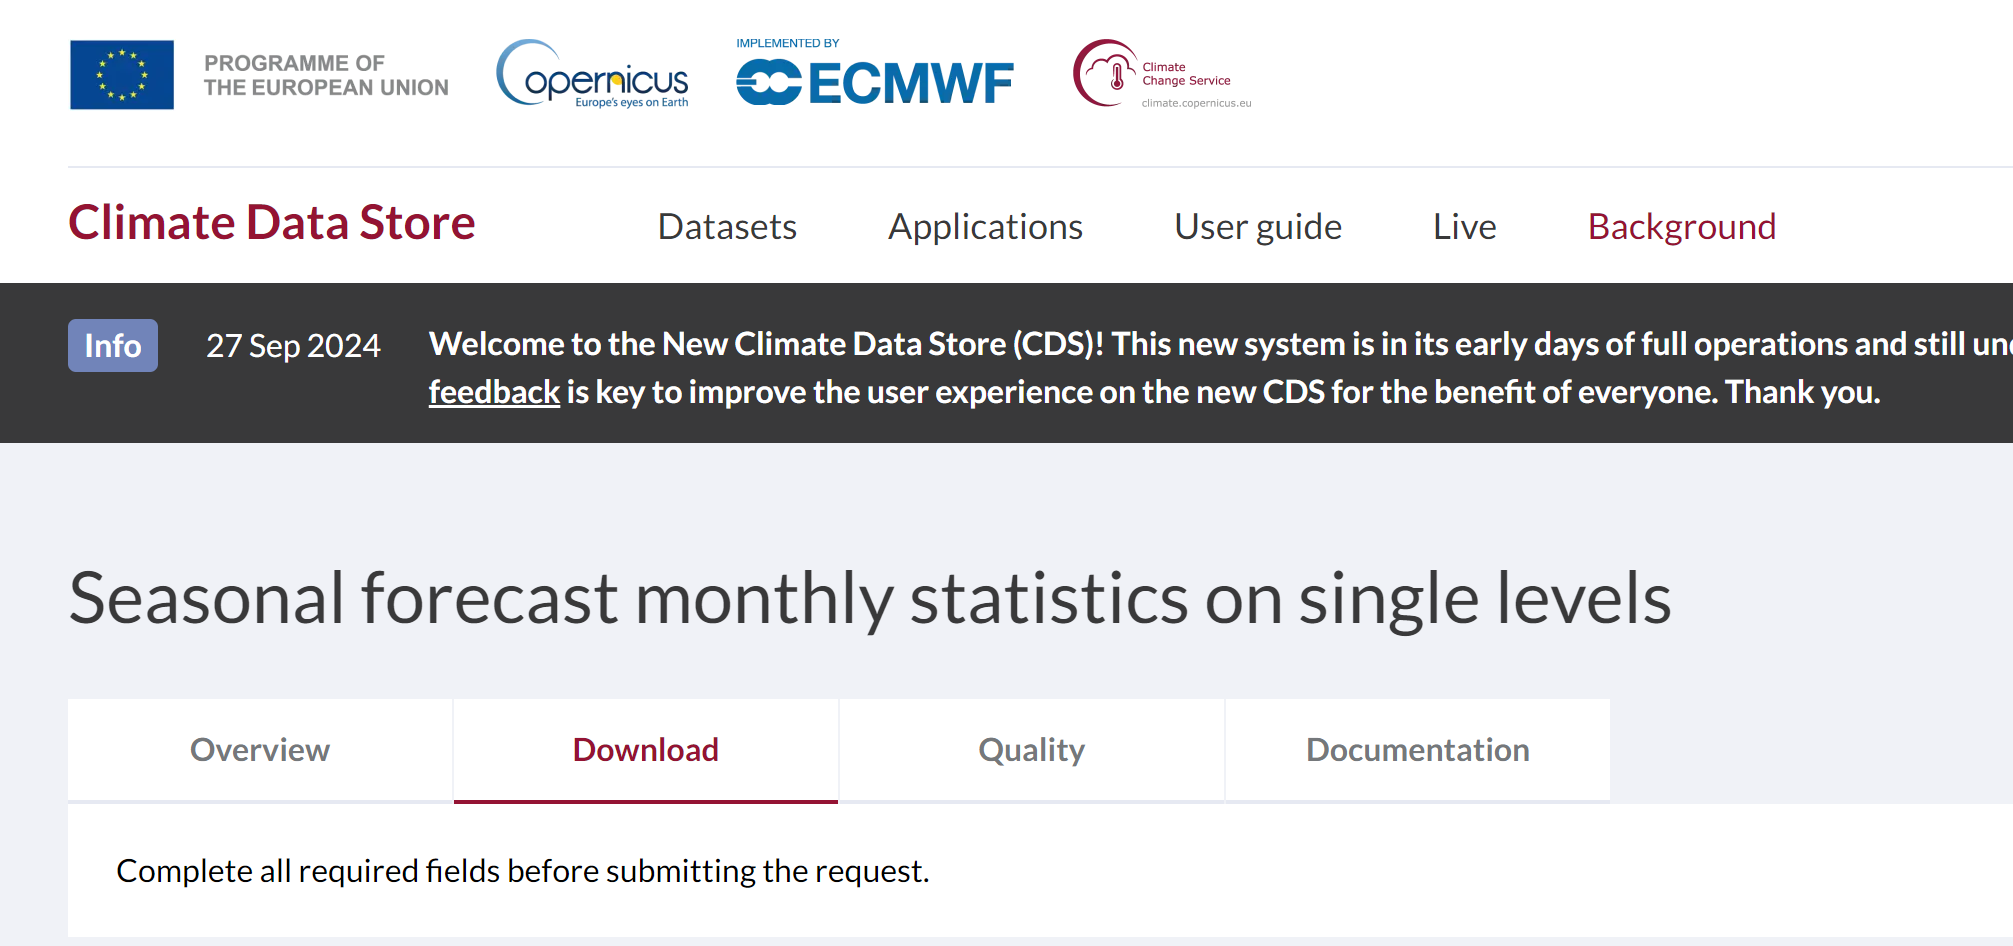

Follow these steps to download the data:

*   select ECMEF in the "Originating centre" field
*   select "51" (model version 51) in the "System" field
*   select interested variable under "Variable" field

```
        Specific humidity (Q) at Pressure Level 850 hPa
        Total column cloud liquid water (single level)
        Total column water vapour (single level)
        Total precipitation (single level)
```

* selecgt "Monthly mean" under "Individual members" field.
* select the years of interest in the "Year" field
* select the month of interest in the "Month" field (e.g. months from June to October).
* select all fields in the "Leadtime hour" field.
* set the following "Geographical area": N = 60, E = -65, S = 20, W = -140
* select GRIB in "Format" field
* Click on "Submit Form" \
You will be forwarded to the "Your requests" page, which allows you to download the data after it has been processed. Here we will take a shortcut and download a pre-compiled ECMWF forecast from Google Drive. The data is available to be downloaded from Google Drive for **1981-Oct2024 (init_month=4 April)**. New data will be appended to this data.

If you want to use the data that you downloaded from Copernicus, click on the folder item on the left side of the screen and upload the data from your local machine or Google Drive. You can also upload your data through this notebook following the next steps.


# **Download ERA5 seasonal reanalysis data from the Copernicus data server.**

**Option 1:**  
*   Monthly average ERA5 data on single level (tclw, tcwv) can be downloaded from the [Copernicus data server](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download).
*   Monthly average ERA5 data on pressur level (q) can be downloaded from the [Copernicus data server](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=download).

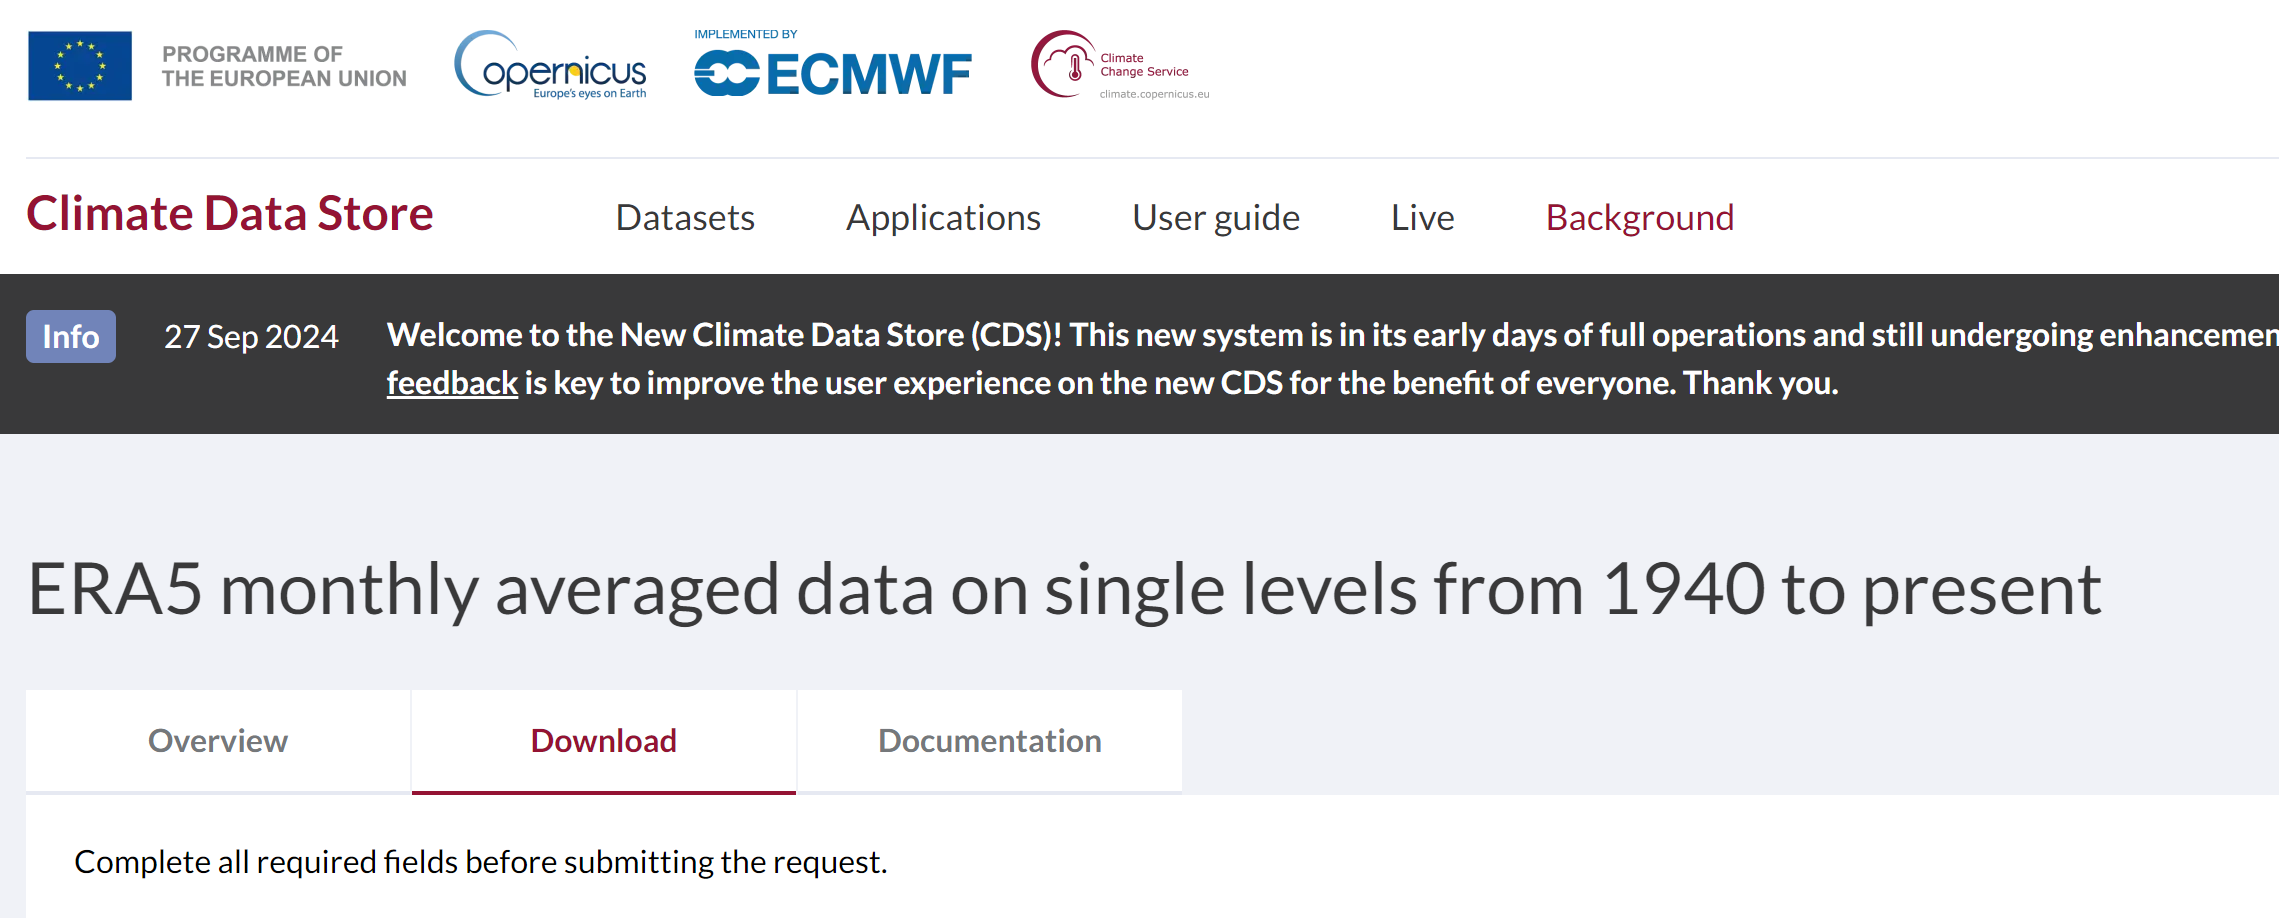


Follow these steps to download the data:

*   select "Monthly averaged reanalysis" in the "Product type" field
*   select `Total column cloud liquid water` in the `Clouds`, `Total precipitation` in the `Precipitation and rain`, or `Total column water vapour` in the `Other` under `Variable` field
*   select the year of interest in the "Year" field
*   select all months in the "Month" field
*   select "00:00" in the "Time" field
*   set the following "Geographical area": N = 60, E = -65, S = 20, W = -140
*   select NetCDF (experimental) in "Format" field
*   Click on "Submit Form"

Pre-compiled monthly ERA5 data (tclw, q, tcwv) is available to be downloaded from Google Drive for **1940-Oct2023**. Your data will be appended to this data.

If you want to use the data that you downloaded from Copernicus click on the folder item on the left side of the screen and upload the data from your local machine or Google Drive.

### Load all nescessary python modules

In [ ]:
# !pip install netCDF4
# !pip install matplotlib==3.1.3
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
# !pip3 install cfgrib
# !pip3 install eccodes
# !pip3 install climetlab
# !pip install --upgrade --no-cache-dir gdown
# !pip install rpy2==3.5.1

In [ ]:
!pip install netCDF4
!pip3 install cfgrib
!pip install eccodes
!pip install --upgrade --no-cache-dir gdown

In [ ]:
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import os
import mpl_toolkits
import pickle
import subprocess
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
# import pylab as plt
import scipy
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
from scipy.ndimage import gaussian_filter
import seaborn as sns
import sys
#import scipy.spatial.qhull as qhull  #scipy.spatial.qhull is deprecated. In SciPy ≥1.10, import directly from scipy.spatial.
from scipy.spatial import Delaunay
import xarray as xr
import cfgrib
#import ecmwflibs
import eccodes
import gdown
from pathlib import Path
from datetime import datetime
from scipy.spatial import Delaunay


In [ ]:
import subprocess

def safe_gdown(file_id, output):
    try:
        subprocess.run(["gdown", file_id, "-O", output], check=True)
        return True
    except subprocess.CalledProcessError:
        print(f"⚠️ Download failed for {file_id}")
        return False


### **Option 2:** downloading data from the Copernicus Climate Data Store (CDS) using the CDS API

**Step 1:** Create a CDS Account
Visit: [Login-Register](https://accounts.ecmwf.int/auth/realms/ecmwf/login-actions/registration?client_id=cds&tab_id=qFk-rVloK1c)

Create an account and confirm your email.

**Step 2:** Get Your API Key
Go to: [https://cds.climate.copernicus.eu/how-to-api](https://cds.climate.copernicus.eu/how-to-api)

After logging in, you will see a code block like this:

```
url: https://cds.climate.copernicus.eu/api/v2
key: 123456:abcd1234-ef56-7890-gh12-ijklmnop3456
```






**Step 3:** Install CDS API Client

In [ ]:
!pip install "cdsapi>=0.7.4"

In [ ]:
import cdsapi, requests, json

**Step 4:** Create .cdsapirc Configuration File. \
**Replace the key with yours.**

In [ ]:
cdsapi_config = """
url: https://cds.climate.copernicus.eu/api
key: 1c0f4b12-dc30-4e32-8c89-7c90961e8a6e
"""

with open('/root/.cdsapirc', 'w') as f:
    f.write(cdsapi_config.strip())

!cat /root/.cdsapirc

url: https://cds.climate.copernicus.eu/api
key: 1c0f4b12-dc30-4e32-8c89-7c90961e8a6e

**Step 5:** Import the Client and Download Data

# ECMWF Pressure Level (Q850)

In [ ]:
client = cdsapi.Client()

dataset = "seasonal-monthly-pressure-levels"
request = {
    "originating_centre": "ecmwf",
    "variable": ["specific_humidity"],
    "pressure_level": ["850"],
    "product_type": ["monthly_mean"],
    "year": ["2025"],
    "month": ["06","07","08","09"],
    "leadtime_month": ["1","2","3","4","5","6"],
    "data_format": "grib",
    "area": [60, -140, 20, -65]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("ECMWF_forecast_Q850.grib")

2025-10-07 17:26:50,785 INFO Request ID is 782c5115-99b3-425a-b5a3-3087a82c89ca
INFO:ecmwf.datastores.legacy_client:Request ID is 782c5115-99b3-425a-b5a3-3087a82c89ca
2025-10-07 17:26:50,956 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:27:05,452 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


4812b8cd30df433ddf9242916331e05.grib:   0%|          | 0.00/7.43M [00:00<?, ?B/s]

'ECMWF_forecast_Q850.grib'

# ECMWF Single Level

In [ ]:
client = cdsapi.Client()
dataset = "seasonal-monthly-single-levels"

years = ["2025"]
months = ["06","07","08","09"]
leadtimes = ["1","2","3","4","5","6"]
area = [60, -140, 20, -65]

vars_list = [
    ("TCLW", "total_column_cloud_liquid_water"),
    ("TCWV", "total_column_water_vapour"),
    ("TP",   "total_precipitation"),
]

def fetch_var(short, cds_var, outpath):
    request = {
        "originating_centre": "ecmwf",
        "system": "51",
        "variable": [cds_var],
        "product_type": ["monthly_mean"],
        "year": years,
        "month": months,
        "leadtime_month": leadtimes,
        "data_format": "grib",
        "area": area
    }
    client.retrieve(dataset, request, outpath)

for short, cds_var in vars_list:
    fetch_var(short, cds_var, f"ECMWF_forecast_{short}.grib")

2025-10-07 17:27:09,138 INFO Request ID is 94692127-948d-4355-89f5-7ff4d9e438c2
INFO:ecmwf.datastores.legacy_client:Request ID is 94692127-948d-4355-89f5-7ff4d9e438c2
2025-10-07 17:27:09,291 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:27:18,071 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-07 17:27:23,282 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


b7a83353636d758905145e0b62cac943.grib:   0%|          | 0.00/7.43M [00:00<?, ?B/s]

2025-10-07 17:27:26,272 INFO Request ID is 1397532b-ec6c-41e2-8efa-9ecd2352efaa
INFO:ecmwf.datastores.legacy_client:Request ID is 1397532b-ec6c-41e2-8efa-9ecd2352efaa
2025-10-07 17:27:26,427 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:27:40,610 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f2d7afe63efd44459339b067140d4753.grib:   0%|          | 0.00/7.43M [00:00<?, ?B/s]

2025-10-07 17:27:43,725 INFO Request ID is 189fca99-a341-4de7-8162-5a98321873a5
INFO:ecmwf.datastores.legacy_client:Request ID is 189fca99-a341-4de7-8162-5a98321873a5
2025-10-07 17:27:43,878 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:27:53,151 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-07 17:27:58,387 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


be89afd255aea695a55e7c5c0fc9fd06.grib:   0%|          | 0.00/7.43M [00:00<?, ?B/s]

# Download ERA5 data over the CONUS




### ERA5 on pressure level

In [ ]:
dataset = "reanalysis-era5-pressure-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["specific_humidity"],
    "pressure_level": ["850"],
    "year": ["2025"],
    "month": ["06", "07", "08"],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [60, -140, 20, -65]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("ERA5_Q850.nc")

2025-10-07 17:28:01,907 INFO Request ID is d7518400-4b8a-4731-b90f-0dae1154f6c1
INFO:ecmwf.datastores.legacy_client:Request ID is d7518400-4b8a-4731-b90f-0dae1154f6c1
2025-10-07 17:28:02,061 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:28:16,016 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-07 17:28:23,902 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


90d7d59af24665d39f84d2dd010026fa.nc:   0%|          | 0.00/250k [00:00<?, ?B/s]

'ERA5_Q850.nc'

### ERA5 on single level

In [ ]:
client = cdsapi.Client()
dataset = "reanalysis-era5-single-levels-monthly-means"

years = ["2025"]
months = ["06", "07", "08"]
time = ["00:00"]
area = [60, -140, 20, -65]

vars_list = [
    ("TP",   "total_precipitation"),
    ("TCWV", "total_column_water_vapour"),
    ("TCLW", "total_column_cloud_liquid_water"),
]

for short, var in vars_list:
    request = {
        "product_type": ["monthly_averaged_reanalysis"],
        "variable": [var],
        "year": years,
        "month": months,
        "time": time,
        "data_format": "netcdf",
        "download_format": "unarchived",
        "area": area
    }
    outname = f"ERA5_{short}.nc"
    client.retrieve(dataset, request, outname)
    print(f"Saved {outname}")

2025-10-07 17:28:26,792 INFO Request ID is ce2d3469-0a48-408b-a3df-b100abefabb1
INFO:ecmwf.datastores.legacy_client:Request ID is ce2d3469-0a48-408b-a3df-b100abefabb1
2025-10-07 17:28:26,951 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:28:35,723 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-07 17:28:40,948 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:29:00,249 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


85ed2d88c6c7ecc701232a394f9c7d48.nc:   0%|          | 0.00/250k [00:00<?, ?B/s]

Saved ERA5_TP.nc


2025-10-07 17:29:03,097 INFO Request ID is 039921dd-dbff-4426-8906-af435c739a5b
INFO:ecmwf.datastores.legacy_client:Request ID is 039921dd-dbff-4426-8906-af435c739a5b
2025-10-07 17:29:03,241 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:29:17,216 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


12ffa27292953a13c7cb7a86b757026d.nc:   0%|          | 0.00/258k [00:00<?, ?B/s]

Saved ERA5_TCWV.nc


2025-10-07 17:29:19,400 INFO Request ID is ba966384-6727-4e47-8f67-bfc77e8171ae
INFO:ecmwf.datastores.legacy_client:Request ID is ba966384-6727-4e47-8f67-bfc77e8171ae
2025-10-07 17:29:19,731 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-07 17:29:28,462 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-10-07 17:29:33,670 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


83b4ba4e9cefc3d05c5a796a15cef259.nc:   0%|          | 0.00/263k [00:00<?, ?B/s]

Saved ERA5_TCLW.nc


# Download Existing Data files (1981-2024)

In [ ]:
import gdown  #Monthly_ERA5
gdown.download('https://drive.google.com/uc?id=1-Ene3mxcK_SKuhhnhO8a1E_Vi-nTew1P', 'ERA_tclw_regional.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1-EvtdkUY5NscPu7qZsuCvBGWIkNEeJ_E', 'ERA_q_regional.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1-U8bju1VY2ku9G4coIF2EfWjSIDhH3cT', 'ERA_tprate_regional.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1-aPEEzVAjzh0Rto7mb4ERw5skWjLWlu0', 'ERA_tcwv_regional.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-Ene3mxcK_SKuhhnhO8a1E_Vi-nTew1P
To: /content/ERA_tclw_regional.csv
100%|██████████| 184k/184k [00:00<00:00, 88.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-EvtdkUY5NscPu7qZsuCvBGWIkNEeJ_E
To: /content/ERA_q_regional.csv
100%|██████████| 184k/184k [00:00<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-U8bju1VY2ku9G4coIF2EfWjSIDhH3cT
To: /content/ERA_tprate_regional.csv
100%|██████████| 185k/185k [00:00<00:00, 54.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-aPEEzVAjzh0Rto7mb4ERw5skWjLWlu0
To: /content/ERA_tcwv_regional.csv
100%|██████████| 182k/182k [00:00<00:00, 80.3MB/s]


'ERA_tcwv_regional.csv'

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=123XixqlrHv8ZAIp9x6HzKf2KALaa-ex7', 'ECMWF_tclw_regional.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1-cpvymYmPFeRLWBqyQgW80ZD5vuKkjto', 'ECMWF_q_regional.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=10YrBiv8Hqz8Q_yg4vbO5haK2I4nE1X4M', 'ECMWF_tprate_regional.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1sANnNeU655tLr4yDaFFiaAH7lnY2y3pt', 'ECMWF_tcwv_regional.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=123XixqlrHv8ZAIp9x6HzKf2KALaa-ex7
To: /content/ECMWF_tclw_regional.csv
100%|██████████| 481k/481k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-cpvymYmPFeRLWBqyQgW80ZD5vuKkjto
To: /content/ECMWF_q_regional.csv
100%|██████████| 500k/500k [00:00<00:00, 99.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=10YrBiv8Hqz8Q_yg4vbO5haK2I4nE1X4M
To: /content/ECMWF_tprate_regional.csv
100%|██████████| 493k/493k [00:00<00:00, 102MB/s]


### **Download csv file of the points coordinates inside of the regions.**

In [ ]:
gdown.download('https://drive.google.com/uc?id=1W87IfqbGoBM-Brbkmw2U-9tksrbTfFK4', '1_ERA_Coordinates_Inside_Polygons_4Reg.csv', quiet=False)

gdown.download('https://drive.google.com/uc?id=10RVQNMwXtaQM9r2Vf7e_OC7yB4euJnUo', '1_ECMWF_Coordinates_Inside_Polygons_4Reg.csv', quiet=False)

### **Creating regional climate variables for the downloaded ERA data**

In [ ]:
import xarray as xr, pandas as pd, numpy as np, glob, os

# === CONFIG ===
VARS = ["Q", "TCWV", "TCLW", "TP"]
COORDS_CSV = "1_ERA_Coordinates_Inside_Polygons_4Reg.csv"
TOL_DEG = 0.15
coords = pd.read_csv(COORDS_CSV)
REGIONS = ['AZ_West','AZ_East','NM_North','NM_South']
ALIASES = {
    "Q":    ["q"],
    "TCWV": ["tcwv", "total_column_water_vapour", "total_column_water_vapor"],
    "TCLW": ["tclw", "total_column_cloud_liquid_water"],
    "TP":   ["tp", "total_precipitation", "pr"]
}

# Find candidate files
cands = glob.glob("ERA*.nc") + glob.glob("*.nc") + glob.glob("*.grib") + glob.glob("*.grb") + glob.glob("*.grb2")
if not cands:
    raise FileNotFoundError("No ERA files found")

# === HELPERS ===
def open_safe(fn):
    try:
        return xr.open_dataset(fn, decode_times=True)
    except Exception:
        return xr.open_dataset(fn, engine="cfgrib")

def nearest(lat_vals, lon_vals, lat, lon):
    ia = np.argmin(np.abs(lat_vals - lat))
    io = np.argmin(np.abs(lon_vals - lon))
    return float(lat_vals[ia]), float(lon_vals[io]), float(np.hypot(lat_vals[ia] - lat, lon_vals[io] - lon))

# === MAIN LOOP ===
for v in VARS:
    ds = None
    vname = None

    for fn in cands:
        try:
            d = open_safe(fn)
        except Exception:
            continue

        for a in ALIASES.get(v, []):
            if a in d.data_vars:
                ds, vname = d, a
                break
        if vname:
            break

    if ds is None or vname is None:
        print(f"[SKIP] {v} not found")
        continue

    print(f"[USING] var {v} -> file {ds.encoding.get('source','<in-memory>')} varname '{vname}'")

    lat_n = next((n for n in ("latitude", "lat", "y") if n in ds.coords), None)
    lon_n = next((n for n in ("longitude", "lon", "x") if n in ds.coords), None)
    if lat_n is None or lon_n is None:
        print(f"[ERROR] no lat/lon for {v}")
        continue

    lats = np.unique(ds[lat_n].values)
    lons = np.unique(ds[lon_n].values)
    ds_var = ds[vname]

    for region in REGIONS:
        pts = coords.loc[coords.Region == region, ["Latitude", "Longitude"]].dropna()
        if pts.empty:
            print(f"[WARN] no coords for {region}")
            continue

        matched = [nearest(lats, lons, lat, lon) for lat, lon in zip(pts.Latitude, pts.Longitude)]
        good = [(la, lo) for la, lo, d in matched if d <= TOL_DEG]
        skipped = len(matched) - len(good)

        if not good:
            print(f"[WARN] {v} {region}: no matched pts within {TOL_DEG}° (skipped {skipped})")
            continue

        lat_arr = np.asarray([g[0] for g in good], dtype=float)
        lon_arr = np.asarray([g[1] for g in good], dtype=float)

        if ds[lat_n].ndim == 1 and ds[lon_n].ndim == 1:
            sel = ds_var.sel({
                lat_n: xr.DataArray(lat_arr, dims="points"),
                lon_n: xr.DataArray(lon_arr, dims="points")
            })
        else:
            lat2 = ds[lat_n].values
            lon2 = ds[lon_n].values
            idxs = [np.unravel_index(np.argmin((lat2 - la) ** 2 + (lon2 - lo) ** 2), lat2.shape)
                    for la, lo in zip(lat_arr, lon_arr)]
            i_idx, j_idx = zip(*idxs)
            sel = ds_var.isel({lat_n: list(i_idx), lon_n: list(j_idx)})

        mean_dims = ["points"] + (["expver"] if "expver" in sel.dims else [])
        ave = sel.mean(dim=mean_dims)

        outfn = f"ERA_ave_{v}_{region}.csv"
        if ave.ndim == 0:
            pd.DataFrame({"Average": [float(ave.item())]}).to_csv(outfn, index=False)
        else:
            ave.to_dataframe(name=v).to_csv(outfn)

        print(f"[SAVED] {outfn} (matched {len(good)} pts, skipped {skipped})")

print("done.")



In [ ]:
import pandas as pd
from glob import glob
import os

# Base file mapping (historic)
base_map = {
    'Q': 'ERA_q_regional.csv',
    'TCWV': 'ERA_tcwv_regional.csv',
    'TCLW': 'ERA_tclw_regional.csv',
    'TP': 'ERA_tprate_regional.csv'
}

# Uploaded regional averages (most recent)
uploaded = sorted(glob('ERA_ave_*.csv'))

for var, base_path in base_map.items():
    df_base = pd.read_csv(base_path)

    for up in uploaded:
        # Match files like ERA_ave_Q_AZ_West.csv
        if f"_{var}_" in up:
            dfu = pd.read_csv(up)
            time_col = 'valid_time' if 'valid_time' in dfu.columns else 'time'

            if var not in dfu.columns:
                print(f"[SKIP] {var} column missing in {up}")
                continue

            region = os.path.basename(up).replace('.csv', '').split('_', 3)[3]

            new = pd.DataFrame({
                'time': pd.to_datetime(dfu[time_col]).dt.strftime('%Y-%m-%d'),
                var.lower(): dfu[var],
                'Month': pd.to_datetime(dfu[time_col]).dt.month,
                'Year': pd.to_datetime(dfu[time_col]).dt.year,
                'Region': region
            })

            df_base = pd.concat([df_base, new], ignore_index=True)

    # Ensure proper datetime columns
    df_base['time'] = pd.to_datetime(df_base['time'], errors='coerce')
    df_base['Year'] = df_base['time'].dt.year
    df_base['Month'] = df_base['time'].dt.month
    df_base['time'] = df_base['time'].dt.strftime('%Y-%m-%d')

    # Filter from 1981 onward
    df_filtered = df_base[df_base['Year'] >= 1981].sort_values(['Region', 'Year', 'Month']).reset_index(drop=True)
    df_filtered = df_filtered[df_filtered['Month'].isin([6, 7, 8, 9, 10])]
    # Save updated file
    outpath = base_path.replace('.csv', '_updated_1981on.csv')
    df_filtered.to_csv(outpath, index=False)
    print(f"[SAVED] {outpath}")

print("✅ ERA_ave files successfully updated and saved (1981 onward)")


### **End of ERA5 processing**

# ECMWF forcast data preparation

In [ ]:
import os, xarray as xr, pandas as pd, multiprocessing as mp

REGIONS = ["AZ_West","AZ_East","NM_North","NM_South"]
COORDINATES_FILE = "1_ERA_Coordinates_Inside_Polygons_4Reg.csv"
SUFFIX = "_2025"
coordinates_df = pd.read_csv(COORDINATES_FILE)

def process_month(var_spec):
    var_name, dir_identifier = var_spec
    print(f"Processing {var_name} ({dir_identifier})...")
    ds = xr.open_dataset(
        f'ECMWF_forecast_{dir_identifier}.grib',
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'dataType': 'fcmean'}},
        decode_timedelta=True
    )

    for region in REGIONS:
        pts = coordinates_df[coordinates_df['Region'] == region]
        lat_lon = list(zip(pts['Latitude'], pts['Longitude']))

        sel = ds.sel(
            latitude=xr.DataArray([lat for lat, _ in lat_lon], dims="points"),
            longitude=xr.DataArray([lon for _, lon in lat_lon], dims="points"),
            method="nearest"
        )

        ave = sel[var_name].mean(dim=['number', 'points'])

        df = ave.to_dataframe().reset_index()
        df["step_num"] = df["step"].astype(str).str.extract(r'(\d+)').astype(float) // 30
        df["time"] = pd.to_datetime(df["time"])
        df["init_Month"] = df["time"].dt.month
        df["valid_time"] = pd.to_datetime(df["valid_time"])
        df["Month"] = df["valid_time"].dt.month - 1
        df.loc[df["Month"] == 0, "Month"] = 12
        df["Year"] = df["valid_time"].dt.year
        df.loc[df["Month"] == 12, "Year"] -= 1
        df["Region"] = region

        # Add seasonal validity check
        df["lead_month"] = df["init_Month"]
        df["month"] = df["Month"]

        season_definitions = {
            "Jun": (df["lead_month"].isin([4, 5, 6])) & (df["month"] == 6),
            "Jul": (df["lead_month"].isin([4, 5, 6, 7])) & (df["month"] == 7),
            "Aug": (df["lead_month"].isin([4, 5, 6, 7, 8])) & (df["month"] == 8),
            "Sep": (df["lead_month"].isin([4, 5, 6, 7, 8])) & (df["month"] == 9),
            "Oct": (df["lead_month"].isin([5, 6, 7, 8])) & (df["month"] == 10),
            "JJASO": (df["lead_month"].isin([5, 6])) & (df["month"].isin([6, 7, 8, 9, 10])),
            "JJA": (df["lead_month"].isin([4, 5, 6])) & (df["month"].isin([6, 7, 8])),
            "JJ": (df["lead_month"].isin([4, 5, 6])) & (df["month"].isin([6, 7])),
            "JASO": (df["lead_month"].isin([5, 6, 7])) & (df["month"].isin([7, 8, 9, 10])),
            "JAS": (df["lead_month"].isin([4, 5, 6, 7])) & (df["month"].isin([7, 8, 9])),
            "JA": (df["lead_month"].isin([4, 5, 6, 7])) & (df["month"].isin([7, 8])),
            "ASO": (df["lead_month"].isin([5, 6, 7, 8])) & (df["month"].isin([8, 9, 10])),
            "AS": (df["lead_month"].isin([4, 5, 6, 7, 8])) & (df["month"].isin([8, 9])),
            "SO": (df["lead_month"].isin([5, 6, 7, 8])) & (df["month"].isin([9, 10])),
        }

        valid_mask = pd.Series(False, index=df.index)
        for cond in season_definitions.values():
            valid_mask |= cond

        df = df[valid_mask]
        df.dropna(subset=[var_name], inplace=True)
        # Save only valid combinations
        output_path = f'ECMWF_ave_{region}_{var_name}{SUFFIX}.csv'
        df.to_csv(output_path, index=False)
        print(f'{output_path} saved with {len(df)} rows.')

    ds.close()
    print(f"Completed {var_name}.")

if __name__ == '__main__':
    variables = [("q","Q850"), ("tprate","TP"), ("tcwv","TCWV"), ("tclw","TCLW")]
    with mp.Pool(processes=min(4, len(variables))) as pool:
        pool.map(process_month, variables)
#ECMWF_ave_AZ_East_tprate_2025.csv

### Append 2025 forecast averages and to each variable’s regional base CSV.

In [ ]:
import pandas as pd, numpy as np, os, re

# config
variables = [("q","Q850"), ("tprate","TP"), ("tcwv","TCWV"), ("tclw","TCCLW")]

for VAR_NAME, DIR_IDENTIFIER in variables:
    BASE_FILE = f"ECMWF_{VAR_NAME.lower()}_regional.csv"
    rows = []
    for region in REGIONS:
        p = f"ECMWF_ave_{region}_{VAR_NAME}{SUFFIX}.csv" # Corrected prefix from ECMWF_ave_ to ECMEF_ave_
        df = pd.read_csv(p)
        df = df[df['Month'].isin([6, 7, 8, 9, 10])]
        df = df[df['init_Month'].isin([4, 5, 6, 7, 8])]
        # Ensure 'surface' exists
        if "surface" not in df.columns:
            df["surface"] = 0.0

        cols = ["time", "step", "surface", "valid_time", VAR_NAME, "step_num", "init_Month", "Region", "Month", "Year"]
        rows.append(df[cols])

    new_2025 = pd.concat(rows, ignore_index=True)

    base = pd.read_csv(BASE_FILE)
    base["time"] = pd.to_datetime(base["time"])
    base["valid_time"] = pd.to_datetime(base["valid_time"])
    base["step"] = base["step"].astype(str)
    base = base[base['Month'].isin([6, 7, 8, 9, 10])]
    base = base[base['init_Month'].isin([4, 5, 6, 7, 8])]

    new_2025["time"] = pd.to_datetime(new_2025["time"])
    new_2025["valid_time"] = pd.to_datetime(new_2025["valid_time"])
    new_2025["step"] = new_2025["step"].astype(str)

    merged = pd.concat([base, new_2025], ignore_index=True)
    merged = merged.drop_duplicates(subset=["Region", "valid_time", "init_Month", "step_num"], keep="last")
    merged = merged.sort_values(["Region", "Year", "Month", "init_Month", "step_num", "valid_time"])

    # Save with _updated in filename
    updated_file = BASE_FILE.replace(".csv", "_updated_1981on.csv")
    merged.to_csv(updated_file, index=False)
    print(f"{updated_file} saved.")

In [ ]:
import pandas as pd
from functools import reduce

path = ''

# read updated regional files
df_q      = pd.read_csv(path + 'ECMWF_q_regional_updated_1981on.csv')
df_tclw   = pd.read_csv(path + 'ECMWF_tclw_regional_updated_1981on.csv')
df_tcwv   = pd.read_csv(path + 'ECMWF_tcwv_regional_updated_1981on.csv')
df_tprate = pd.read_csv(path + 'ECMWF_tprate_regional_updated_1981on.csv')

df_q = df_q[df_q['Month'].isin([6, 7, 8, 9, 10])]
df_tclw = df_tclw[df_tclw['Month'].isin([6, 7, 8, 9, 10])]
df_tcwv = df_tcwv[df_tcwv['Month'].isin([6, 7, 8, 9, 10])]
df_tprate = df_tprate[df_tprate['Month'].isin([6, 7, 8, 9, 10])]

# keep only merge keys + value columns, dedup on keys (keep last)
keys = ['Year','Month','init_Month','Region']
df_q      = df_q     [keys + ['q']     ].drop_duplicates(keys, keep='last')
df_tclw   = df_tclw  [keys + ['tclw']  ].drop_duplicates(keys, keep='last')
df_tcwv   = df_tcwv  [keys + ['tcwv']  ].drop_duplicates(keys, keep='last')
df_tprate = df_tprate[keys + ['tprate']].drop_duplicates(keys, keep='last')

# merge all on keys
hindcast_combined = reduce(lambda x,y: pd.merge(x, y, on=keys, how='outer'),
                           [df_q, df_tclw, df_tcwv, df_tprate])

# sort and save
hindcast_combined = hindcast_combined.sort_values(['Region','Year','init_Month','Month'])
out = '5_combined_forecast_variables.csv'
hindcast_combined.to_csv(path + out, index=False)
print(f"Combined data saved to {out}.")
